In [11]:
"""
run_experiment_standalone.py
----------------------------
Compute similarity metrics between two PNML Petri nets:
- PES (Process Element Similarity) on events and relations, with F1-score
- TAR (Transition Adjacency Relations) with F1-score
- PM4Py conformance metrics: fitness, precision, generalization, simplicity
"""

import pandas as pd
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# -----------------------------
# Utility functions
# -----------------------------
def jaccard_similarity(set1, set2):
    inter = len(set1 & set2)
    union = len(set1 | set2)
    return inter / union if union > 0 else 0

def precision_recall_f1(gold_set, predicted_set):
    tp = len(gold_set & predicted_set)
    precision = tp / len(predicted_set) if predicted_set else 0
    recall = tp / len(gold_set) if gold_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

def extract_events_and_relations(net):
    """Extract visible transitions (events) and direct relations from a Petri net"""
    events = {t.label for t in net.transitions if t.label}
    relations = set()
    for arc in net.arcs:
        # Only consider arcs where both source and target are transitions
        if hasattr(arc.source, "label") and hasattr(arc.target, "label"):
            if arc.source.label and arc.target.label:
                relations.add((arc.source.label, arc.target.label))
    return events, relations

def extract_tar_from_pnml(pnml_path, no_traces=100):
    """Extract Transition Adjacency Relations (TAR) from PNML via playout simulation"""
    net, im, fm = pnml_importer.apply(pnml_path)
    log = simulator.apply(net, im, variant=simulator.Variants.BASIC_PLAYOUT,
                          parameters={"no_traces": no_traces})
    tar = set()
    for trace in log:
        events = [e["concept:name"] for e in trace]
        for i in range(len(events) - 1):
            tar.add((events[i], events[i+1]))
    return tar

def dab_similarity(tar1, tar2):
    """Compute DAB similarity between TAR sets"""
    inter = tar1 & tar2
    union = tar1 | tar2
    return len(inter) / len(union) if union else 1.0

# -----------------------------
# Main computation
# -----------------------------
# Replace with your PNML file paths
model_a_path = "birthCertificate_p31.pnml"
model_b_path = "birthCertificate_p32.pnml"

# Load Petri nets
net_a, im_a, fm_a = pnml_importer.apply(model_a_path)
net_b, im_b, fm_b = pnml_importer.apply(model_b_path)

# --- PES
events_a, relations_a = extract_events_and_relations(net_a)
events_b, relations_b = extract_events_and_relations(net_b)

pes_events_jaccard = jaccard_similarity(events_a, events_b)
pes_relations_jaccard = jaccard_similarity(relations_a, relations_b)
pes_events_precision, pes_events_recall, pes_events_f1 = precision_recall_f1(events_a, events_b)
pes_relations_precision, pes_relations_recall, pes_relations_f1 = precision_recall_f1(relations_a, relations_b)

# --- TAR
tar_a = extract_tar_from_pnml(model_a_path)
tar_b = extract_tar_from_pnml(model_b_path)
tar_similarity = dab_similarity(tar_a, tar_b)
tar_precision, tar_recall, tar_f1 = precision_recall_f1(tar_a, tar_b)

# --- PM4Py metrics
simulated_log = simulator.apply(
    net_a, im_a, variant=simulator.Variants.BASIC_PLAYOUT,
    parameters={"max_trace_length": 15, "no_traces": 30}
)
results = alignments.apply(simulated_log, net_b, im_b, fm_b)
avg_fitness = sum(r["fitness"] for r in results) / len(results)
precision_val = precision_evaluator.apply(simulated_log, net_b, im_b, fm_b)
generalization = generalization_evaluator.apply(simulated_log, net_b, im_b, fm_b)
simplicity = simplicity_evaluator.apply(net_b)

# --- Print all metrics
print("=== PES ===")
print(f"Events - Jaccard: {pes_events_jaccard:.3f}, Precision: {pes_events_precision:.3f}, Recall: {pes_events_recall:.3f}, F1: {pes_events_f1:.3f}")
print(f"Relations - Jaccard: {pes_relations_jaccard:.3f}, Precision: {pes_relations_precision:.3f}, Recall: {pes_relations_recall:.3f}, F1: {pes_relations_f1:.3f}")

print("\n=== TAR ===")
print(f"TAR similarity: {tar_similarity:.3f}, Precision: {tar_precision:.3f}, Recall: {tar_recall:.3f}, F1: {tar_f1:.3f}")

print("\n=== PM4Py Metrics ===")
print(f"Fitness: {avg_fitness:.3f}, Precision: {precision_val:.3f}, Generalization: {generalization:.3f}, Simplicity: {simplicity:.3f}")


aligning log, completed variants ::   0%|          | 0/161 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/789 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/161 [00:00<?, ?it/s]

=== PES ===
Events - Jaccard: 0.029, Precision: 0.067, Recall: 0.050, F1: 0.057
Relations - Jaccard: 0.000, Precision: 0.000, Recall: 0.000, F1: 0.000

=== TAR ===
TAR similarity: 0.018, Precision: 0.038, Recall: 0.032, F1: 0.035

=== PM4Py Metrics ===
Fitness: 0.238, Precision: 0.000, Generalization: 0.098, Simplicity: 0.787


In [15]:
import pandas as pd
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# -----------------------------
# Utility functions
# -----------------------------
def jaccard_similarity(set1, set2):
    inter = len(set1 & set2)
    union = len(set1 | set2)
    return inter / union if union > 0 else 0

def precision_recall_f1(gold_set, predicted_set):
    tp = len(gold_set & predicted_set)
    precision = tp / len(predicted_set) if predicted_set else 0
    recall = tp / len(gold_set) if gold_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

def extract_events_and_relations(net):
    events = {t.label for t in net.transitions if t.label}
    relations = set()
    for arc in net.arcs:
        if hasattr(arc.source, "label") and hasattr(arc.target, "label"):
            if arc.source.label and arc.target.label:
                relations.add((arc.source.label, arc.target.label))
    return events, relations

def extract_tar_from_pnml(pnml_path, no_traces=100):
    net, im, fm = pnml_importer.apply(pnml_path)
    log = simulator.apply(net, im, variant=simulator.Variants.BASIC_PLAYOUT,
                          parameters={"no_traces": no_traces})
    tar = set()
    for trace in log:
        events = [e["concept:name"] for e in trace]
        for i in range(len(events) - 1):
            tar.add((events[i], events[i+1]))
    return tar

def dab_similarity(tar1, tar2):
    inter = tar1 & tar2
    union = tar1 | tar2
    return len(inter) / len(union) if union else 1.0

# -----------------------------
# Main computation
# -----------------------------
model_a_path = "birthCertificate_p31.pnml"
model_b_path = "birthCertificate_p32.pnml"

net_a, im_a, fm_a = pnml_importer.apply(model_a_path)
net_b, im_b, fm_b = pnml_importer.apply(model_b_path)

# --- PES
events_a, relations_a = extract_events_and_relations(net_a)
events_b, relations_b = extract_events_and_relations(net_b)

pes_events_jaccard = jaccard_similarity(events_a, events_b)
pes_relations_jaccard = jaccard_similarity(relations_a, relations_b)
pes_events_precision, pes_events_recall, pes_events_f1 = precision_recall_f1(events_a, events_b)
pes_relations_precision, pes_relations_recall, pes_relations_f1 = precision_recall_f1(relations_a, relations_b)

# --- TAR
tar_a = extract_tar_from_pnml(model_a_path)
tar_b = extract_tar_from_pnml(model_b_path)
tar_similarity = dab_similarity(tar_a, tar_b)
tar_precision, tar_recall, tar_f1 = precision_recall_f1(tar_a, tar_b)

# --- PM4Py metrics
simulated_log = simulator.apply(
    net_a, im_a, variant=simulator.Variants.BASIC_PLAYOUT,
    parameters={"max_trace_length": 15, "no_traces": 30}
)
results = alignments.apply(simulated_log, net_b, im_b, fm_b)
avg_fitness = sum(r["fitness"] for r in results) / len(results)
pm4py_precision = precision_evaluator.apply(simulated_log, net_b, im_b, fm_b)
pm4py_generalization = generalization_evaluator.apply(simulated_log, net_b, im_b, fm_b)
pm4py_simplicity = simplicity_evaluator.apply(net_b)

# --- Print metrics with F1-score
print("=== PES ===")
print(f"Events: Jaccard={pes_events_jaccard:.3f}, Precision={pes_events_precision:.3f}, Recall={pes_events_recall:.3f}, F1={pes_events_f1:.3f}")
print(f"Relations: Jaccard={pes_relations_jaccard:.3f}, Precision={pes_relations_precision:.3f}, Recall={pes_relations_recall:.3f}, F1={pes_relations_f1:.3f}")

print("\n=== TAR ===")
print(f"TAR similarity={tar_similarity:.3f}, Precision={tar_precision:.3f}, Recall={tar_recall:.3f}, F1={tar_f1:.3f}")

print("\n=== PM4Py Metrics ===")
print(f"Fitness={avg_fitness:.3f}, Precision={pm4py_precision:.3f}, Generalization={pm4py_generalization:.3f}, Simplicity={pm4py_simplicity:.3f}")


aligning log, completed variants ::   0%|          | 0/163 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/765 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/163 [00:00<?, ?it/s]

=== PES ===
Events: Jaccard=0.029, Precision=0.067, Recall=0.050, F1=0.057
Relations: Jaccard=0.000, Precision=0.000, Recall=0.000, F1=0.000

=== TAR ===
TAR similarity=0.018, Precision=0.038, Recall=0.032, F1=0.035

=== PM4Py Metrics ===
Fitness=0.239, Precision=0.000, Generalization=0.049, Simplicity=0.787


In [19]:
"""
run_experiment_standalone.py
----------------------------
Compute similarity metrics between two PNML Petri nets:
- PES (Process Element Similarity) on events and relations, with F1-score
- TAR (Transition Adjacency Relations) with F1-score
- PM4Py conformance metrics: fitness, precision, F1-score (harmonic mean), generalization, simplicity
"""

import pandas as pd
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# -----------------------------
# Utility functions
# -----------------------------
def jaccard_similarity(set1, set2):
    inter = len(set1 & set2)
    union = len(set1 | set2)
    return inter / union if union > 0 else 0

def precision_recall_f1(gold_set, predicted_set):
    tp = len(gold_set & predicted_set)
    precision = tp / len(predicted_set) if predicted_set else 0
    recall = tp / len(gold_set) if gold_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

def harmonic_f1(a, b):
    """Compute harmonic mean between two values (like F1-score)"""
    return 2 * a * b / (a + b) if (a + b) else 0

def extract_events_and_relations(net):
    events = {t.label for t in net.transitions if t.label}
    relations = set()
    for arc in net.arcs:
        if hasattr(arc.source, "label") and hasattr(arc.target, "label"):
            if arc.source.label and arc.target.label:
                relations.add((arc.source.label, arc.target.label))
    return events, relations

def extract_tar_from_pnml(pnml_path, no_traces=100):
    net, im, fm = pnml_importer.apply(pnml_path)
    log = simulator.apply(net, im, variant=simulator.Variants.BASIC_PLAYOUT,
                          parameters={"no_traces": no_traces})
    tar = set()
    for trace in log:
        events = [e["concept:name"] for e in trace]
        for i in range(len(events) - 1):
            tar.add((events[i], events[i+1]))
    return tar

def dab_similarity(tar1, tar2):
    inter = tar1 & tar2
    union = tar1 | tar2
    return len(inter) / len(union) if union else 1.0

# -----------------------------
# Main computation
# -----------------------------
model_a_path = "birthCertificate_p31.pnml"
model_b_path = "birthCertificate_p32.pnml"

net_a, im_a, fm_a = pnml_importer.apply(model_a_path)
net_b, im_b, fm_b = pnml_importer.apply(model_b_path)

# --- PES
events_a, relations_a = extract_events_and_relations(net_a)
events_b, relations_b = extract_events_and_relations(net_b)

pes_events_jaccard = jaccard_similarity(events_a, events_b)
pes_relations_jaccard = jaccard_similarity(relations_a, relations_b)
pes_events_precision, pes_events_recall, pes_events_f1 = precision_recall_f1(events_a, events_b)
pes_relations_precision, pes_relations_recall, pes_relations_f1 = precision_recall_f1(relations_a, relations_b)

# --- TAR
tar_a = extract_tar_from_pnml(model_a_path)
tar_b = extract_tar_from_pnml(model_b_path)
tar_similarity = dab_similarity(tar_a, tar_b)
tar_precision, tar_recall, tar_f1 = precision_recall_f1(tar_a, tar_b)

# --- PM4Py metrics
simulated_log = simulator.apply(
    net_a, im_a, variant=simulator.Variants.BASIC_PLAYOUT,
    parameters={"max_trace_length": 15, "no_traces": 30}
)
results = alignments.apply(simulated_log, net_b, im_b, fm_b)
avg_fitness = sum(r["fitness"] for r in results) / len(results)
pm4py_precision = precision_evaluator.apply(simulated_log, net_b, im_b, fm_b)
pm4py_generalization = generalization_evaluator.apply(simulated_log, net_b, im_b, fm_b)
pm4py_simplicity = simplicity_evaluator.apply(net_b)
pm4py_f1 = harmonic_f1(avg_fitness, pm4py_precision)  # F1-like measure

# --- Print metrics with F1-score
print("=== PES ===")
print(f"Events: Jaccard={pes_events_jaccard:.3f}, Precision={pes_events_precision:.3f}, Recall={pes_events_recall:.3f}, F1={pes_events_f1:.3f}")
print(f"Relations: Jaccard={pes_relations_jaccard:.3f}, Precision={pes_relations_precision:.3f}, Recall={pes_relations_recall:.3f}, F1={pes_relations_f1:.3f}")

print("\n=== TAR ===")
print(f"TAR similarity={tar_similarity:.3f}, Precision={tar_precision:.3f}, Recall={tar_recall:.3f}, F1={tar_f1:.3f}")

print("\n=== PM4Py Metrics ===")
print(f"Fitness={avg_fitness:.3f}, Precision={pm4py_precision:.3f}, F1={pm4py_f1:.3f}, "
      f"Generalization={pm4py_generalization:.3f}, Simplicity={pm4py_simplicity:.3f}")


aligning log, completed variants ::   0%|          | 0/177 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/877 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/177 [00:00<?, ?it/s]

=== PES ===
Events: Jaccard=0.029, Precision=0.067, Recall=0.050, F1=0.057
Relations: Jaccard=0.000, Precision=0.000, Recall=0.000, F1=0.000

=== TAR ===
TAR similarity=0.018, Precision=0.038, Recall=0.032, F1=0.035

=== PM4Py Metrics ===
Fitness=0.239, Precision=0.000, F1=0.000, Generalization=0.098, Simplicity=0.787


In [23]:
"""
run_experiment_standalone.py
----------------------------
Compute similarity metrics between two PNML Petri nets:
- PES (Process Element Similarity) on events and relations, with F1-score
- TAR (Transition Adjacency Relations) with F1-score
- PM4Py conformance metrics: fitness, precision, F1-score (harmonic mean), generalization, simplicity
- Save all metrics in CSV: pairs.csv
"""

import pandas as pd
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# -----------------------------
# Utility functions
# -----------------------------
def jaccard_similarity(set1, set2):
    inter = len(set1 & set2)
    union = len(set1 | set2)
    return inter / union if union > 0 else 0

def precision_recall_f1(gold_set, predicted_set):
    tp = len(gold_set & predicted_set)
    precision = tp / len(predicted_set) if predicted_set else 0
    recall = tp / len(gold_set) if gold_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

def harmonic_f1(a, b):
    return 2 * a * b / (a + b) if (a + b) else 0

def extract_events_and_relations(net):
    events = {t.label for t in net.transitions if t.label}
    relations = set()
    for arc in net.arcs:
        if hasattr(arc.source, "label") and hasattr(arc.target, "label"):
            if arc.source.label and arc.target.label:
                relations.add((arc.source.label, arc.target.label))
    return events, relations

def extract_tar_from_pnml(pnml_path, no_traces=100):
    net, im, fm = pnml_importer.apply(pnml_path)
    log = simulator.apply(net, im, variant=simulator.Variants.BASIC_PLAYOUT,
                          parameters={"no_traces": no_traces})
    tar = set()
    for trace in log:
        events = [e["concept:name"] for e in trace]
        for i in range(len(events) - 1):
            tar.add((events[i], events[i+1]))
    return tar

def dab_similarity(tar1, tar2):
    inter = tar1 & tar2
    union = tar1 | tar2
    return len(inter) / len(union) if union else 1.0

# -----------------------------
# Main computation
# -----------------------------
model_a_path = "birthCertificate_p31.pnml"
model_b_path = "birthCertificate_p32.pnml"

net_a, im_a, fm_a = pnml_importer.apply(model_a_path)
net_b, im_b, fm_b = pnml_importer.apply(model_b_path)

# --- PES
events_a, relations_a = extract_events_and_relations(net_a)
events_b, relations_b = extract_events_and_relations(net_b)

pes_events_jaccard = jaccard_similarity(events_a, events_b)
pes_relations_jaccard = jaccard_similarity(relations_a, relations_b)
pes_events_precision, pes_events_recall, pes_events_f1 = precision_recall_f1(events_a, events_b)
pes_relations_precision, pes_relations_recall, pes_relations_f1 = precision_recall_f1(relations_a, relations_b)

# --- TAR
tar_a = extract_tar_from_pnml(model_a_path)
tar_b = extract_tar_from_pnml(model_b_path)
tar_similarity = dab_similarity(tar_a, tar_b)
tar_precision, tar_recall, tar_f1 = precision_recall_f1(tar_a, tar_b)

# --- PM4Py metrics
simulated_log = simulator.apply(
    net_a, im_a, variant=simulator.Variants.BASIC_PLAYOUT,
    parameters={"max_trace_length": 15, "no_traces": 30}
)
results = alignments.apply(simulated_log, net_b, im_b, fm_b)
avg_fitness = sum(r["fitness"] for r in results) / len(results)
pm4py_precision = precision_evaluator.apply(simulated_log, net_b, im_b, fm_b)
pm4py_generalization = generalization_evaluator.apply(simulated_log, net_b, im_b, fm_b)
pm4py_simplicity = simplicity_evaluator.apply(net_b)
pm4py_f1 = harmonic_f1(avg_fitness, pm4py_precision)

# --- Save all metrics in CSV
df = pd.DataFrame([{
    "model_a": model_a_path,
    "model_b": model_b_path,
    "pes_events_jaccard": pes_events_jaccard,
    "pes_events_precision": pes_events_precision,
    "pes_events_recall": pes_events_recall,
    "pes_events_f1": pes_events_f1,
    "pes_relations_jaccard": pes_relations_jaccard,
    "pes_relations_precision": pes_relations_precision,
    "pes_relations_recall": pes_relations_recall,
    "pes_relations_f1": pes_relations_f1,
    "tar_similarity": tar_similarity,
    "tar_precision": tar_precision,
    "tar_recall": tar_recall,
    "tar_f1": tar_f1,
    "pm4py_fitness": avg_fitness,
    "pm4py_precision": pm4py_precision,
    "pm4py_f1": pm4py_f1,
    "pm4py_generalization": pm4py_generalization,
    "pm4py_simplicity": pm4py_simplicity
}])

csv_path = "pairs.csv"
df.to_csv(csv_path, index=False)
print(f"✅ All metrics saved to {csv_path}")


aligning log, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/775 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

✅ All metrics saved to pairs.csv


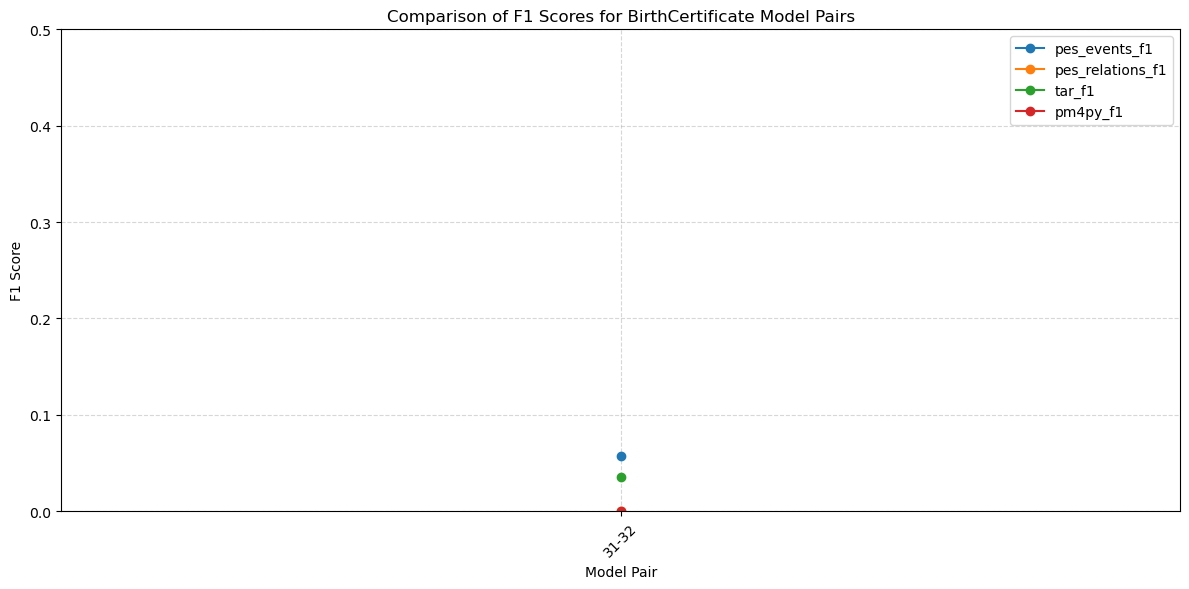

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
# --- Visualizzazione dei risultati aggregati
# Leggi il CSV appena salvato
df = pd.read_csv("pairs.csv")

# Creiamo etichette per le coppie (ad esempio: "31-32")
df["pair"] = df["model_a"].str.extract(r'(\d+)') + "-" + df["model_b"].str.extract(r'(\d+)')

# Selezioniamo metriche F1 da confrontare
metrics_f1 = ["pes_events_f1", "pes_relations_f1", "tar_f1", "pm4py_f1"]

# Imposta dimensione grafico
plt.figure(figsize=(12, 6))

# Plot a barre per ogni metrica F1
for metric in metrics_f1:
    plt.plot(df["pair"], df[metric], marker='o', label=metric)

plt.xlabel("Model Pair")
plt.ylabel("F1 Score")
plt.title("Comparison of F1 Scores for BirthCertificate Model Pairs")
plt.xticks(rotation=45)
plt.ylim(0, 0.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()